In [1]:
import calendar
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from descartes import PolygonPatch
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

In [2]:
training_data_file = '../data/training_data/1992-1997_training_data.csv'
box_training_data_file = '../data/training_data/1992-1997_training_data_box.csv'
weather_data_box = '../data/NOAA_weather_data/1992-1997_california_box_all.csv'
states_shapefile = '../data/spatial_data/cb_2018_us_state_500k.shp'

LAT_START = 31.52
LON_START = -125.48
LAT_END = 43.0
LON_END = -113.131
GRID_SPACING = 0.1

heatmap_contour_levels = 50
heatmap_time_subset = '1997-11-23 18:00:00'

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig_rows = 7
fig_cols = 3
plot_height = 35
plot_width = 30

plot_locations = [
    (0,0),(0,1),(0,2),
    (1,0),(1,1),(1,2),
    (2,0),(2,1),(2,2),
    (3,0),(3,1),(3,2),
    (4,0),(4,1),(4,2),
    (5,0),(5,1),(5,2),
    (6,0),(6,1)
]

data_types = [
    'air.sfc',  # Surface air temp
    'air.2m',   # Air temp. at 2 meters above surface
    'apcp',     # Accumulated precipitation
    'rhum.2m',  # Relative humidity 2 meters above surface
    'dpt.2m',   # Dew point temp. 2 meters above surface
    'pres.sfc', # Pressure at surface
    'uwnd.10m', # u component of wind (positive = from west) 10 meters above surface
    'vwnd.10m', # v component of wind (positive = from south) 10 meters above surface
    'veg',      # Vegitation at surface
    'dlwrf',    # Downward long wave radiation flux at surface
    'dswrf',    # Downward short wave radiation flux at surface
    'lcdc',     # Low cloud area fraction
    'hcdc',     # High cloud area fraction
    'mcdc',     # Medium cloud area fraction
    'hpbl',     # Planetary boundary layer height
    'prate',    # Precipitation rate
    'vis',      # Visibility
    'ulwrf.sfc',# Upward long wave radiation flux at surface
    'lat',
    'lon'
]

plot_titles = [
    'Surface Air Temperature',
    'Air Temperature at 2 Meters',
    'Accumulated Precipitation',
    'Relative Humidity at 2 Meters',
    'Dew Point Temperature',
    'Surface Pressure',
    'East-west Component of Wind',
    'North-south Component of Wind',
    'Vegitation Coverage',
    'Downward Long Wave EM Flux',
    'Downward Short Wave EM Flux',
    'Low Height Cloud Coverage',
    'High Height Cloud Coverage',
    'Medium Height Cloud Coverage',
    'Planetary Boundary Layer Height',
    'Precipitation Rate',
    'Visibility',
    'Upward Long Wave EM Flux',
    'Latitude',
    'Longitude'
]

weather_variable_labels = [
    'Temp. (K)',
    'Temp (K)',
    'Precipitation (in.)',
    'Humidity (%)',
    'Temp (K)',
    'Pressure (kPa)',
    'Speed (mph)',
    'Speed (mph)',
    'Coverage (%)',
    'Flux',
    'Flux',
    'Coverage Fraction',
    'Coverage Fraction',
    'Coverage Fraction',
    'Height (m)',
    'Rate',
    'Visibility',
    'Flux',
    'Latitude',
    'Longitude'
]

def get_california_polygon(shapefile):
    gdf = gpd.read_file(shapefile)
    california = gdf[gdf['NAME'] == 'California']
    return(california)

def regularize_grid(data, data_type):
    #data = data.dropna()
    
    # data coordinates and values
    x = data['lon']
    y = data['lat']
    z = data[data_type]

    # target grid to interpolate to
    xi = np.arange(LON_START,LON_END,GRID_SPACING)
    yi = np.arange(LAT_START,LAT_END,GRID_SPACING)
    xi,yi = np.meshgrid(xi,yi)

    # interpolate
    zi = griddata((x,y),z,(xi,yi),method='linear')
    
    return xi, yi, zi

def calculate_frac_ignitions(data_type, num_bins):
    max_val = max(data[data_type])
    min_val = min(data[data_type])
    freq = (max_val - min_val) / num_bins
    bins = pd.interval_range(start=min_val, freq=freq, end=max_val)
    ignitions = pd.cut(ignition[data_type], bins=bins)
    all_data = pd.cut(data[data_type], bins=bins)
    fraction_ignitions = ignitions.value_counts() / all_data.value_counts()
    real_bin_nums = range(len(fraction_ignitions))
    return(fraction_ignitions, real_bin_nums)

def CDF_plot(plot_location, data, data_type, title, xlabel, ylabel):
    values, base = np.histogram(data[data_type], bins=40)
    cumulative = np.cumsum(values) / len(data)

    ax[plot_location].plot(base[:-1], cumulative)
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[plot_location].set_ylim([-0.05,1.05])
    
    return ax

def map_plot(plot_location, california_land_mass, xi, yi, zi, title, num_contour_levels):
    ax[plot_location].add_patch(PolygonPatch(california_land_mass, fc='none', ec='black', lw='2', zorder=2))
    ax[plot_location].contourf(xi, yi, zi, num_contour_levels, cmap='viridis')
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].axis('scaled')
    return ax

def boxplot(plot_location, no_ignition, ignition, data_type, title, xlabel, ylabel):
    plot_data = [no_ignition[data_type], ignition[data_type]]

    ax[plot_location].boxplot(plot_data, widths = 0.6, patch_artist = True)
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].set_xticklabels(['no','yes'])
    
    return ax
    
def binned_scatterplot(plot_location, data_type, title, xlabel, ylabel, num_bins):
    plot_data, real_bin_nums = calculate_frac_ignitions(data_type, num_bins)

    ax[plot_location].plot(real_bin_nums, plot_data, 'o')
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_xticks([])
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[plot_location].set_ylim([-0.05,0.125])
    
    return ax

In [3]:
data = pd.read_csv(training_data_file, low_memory=False)
box_data = pd.read_csv(box_training_data_file, low_memory=False)

d = dict(enumerate(calendar.month_abbr))

data['weather_bin_time'] = pd.to_datetime(data['weather_bin_time'])
data['pres.sfc'] = data['pres.sfc'] / 1000
data['ignition'].fillna(0, inplace=True)
data['weather_bin_month'] = data['weather_bin_time'].dt.month
data['weather_bin_month'] = data['weather_bin_month'].map(d)
data['weather_bin_year'] = data['weather_bin_time'].dt.year

fires_per_bin = box_data.groupby(['lat', 'lon'], as_index=False)['ignition'].sum()
fires_per_month = data.groupby(['weather_bin_month','weather_bin_year'], as_index=False)['ignition'].sum()

fires_per_month['ignition'] = fires_per_month['ignition'] / 8 # need to divide by 8 here because currently
                                                              # each fire is assigned to every 3 hr bin on the 
                                                              # day of it's discovery    
ignition = data[data['ignition'] == 1]
no_ignition = data[data['ignition'] == 0]

california = get_california_polygon(states_shapefile)
multipoly = california.loc[16, 'geometry']
california_land_mass = multipoly[-1]

In [4]:
data.head()

,weather_bin_time,lat,lon,air.sfc,air.2m,apcp,crain,rhum.2m,dpt.2m,pres.sfc,...,hpbl,prate,vis,ulwrf.sfc,fire_discovery_time,size,size_class,ignition,weather_bin_month,weather_bin_year
0,1992-01-01,40.29749,-124.3408,284.35388,284.81824,0.0,0.0,88.3125,282.89040,100.17356,...,533.4578,-0.000003,20007.979,359.9375,NaN,NaN,NaN,0.0,Jan,1992
1,1992-01-01,38.96153,-123.5579,285.66638,286.25574,0.0,0.0,67.9375,280.43730,99.07356,...,671.8578,-0.000003,20007.979,353.8750,NaN,NaN,NaN,0.0,Jan,1992
2,1992-01-01,39.24150,-123.6393,286.04138,286.81824,0.0,0.0,69.8125,281.35916,99.57356,...,786.9578,-0.000003,20007.979,349.4375,NaN,NaN,NaN,0.0,Jan,1992
3,1992-01-01,39.52163,-123.7215,286.04138,286.81824,0.0,0.0,69.8125,281.35916,99.47356,...,917.4578,-0.000003,20007.979,349.4375,NaN,NaN,NaN,0.0,Jan,1992
4,1992-01-01,39.80193,-123.8045,283.35388,284.06824,0.0,0.0,68.8125,278.55447,96.57356,...,833.7578,-0.000003,20007.979,341.6250,NaN,NaN,NaN,0.0,Jan,1992


In [5]:
data.tail()

,weather_bin_time,lat,lon,air.sfc,air.2m,apcp,crain,rhum.2m,dpt.2m,pres.sfc,...,hpbl,prate,vis,ulwrf.sfc,fire_discovery_time,size,size_class,ignition,weather_bin_month,weather_bin_year
7276539,1997-12-31 21:00:00,34.06700,-114.6695,294.46613,290.61084,0.0,0.0,41.214478,277.27270,98.09705,...,425.36115,-0.000004,20008.086,422.7500,NaN,NaN,NaN,0.0,Dec,1997
7276540,1997-12-31 21:00:00,34.34740,-114.7045,294.84113,291.11084,0.0,0.0,30.401978,273.46020,95.29705,...,491.76114,-0.000004,20008.086,421.7500,NaN,NaN,NaN,0.0,Dec,1997
7276541,1997-12-31 21:00:00,34.62812,-114.7398,295.96613,291.17334,0.0,0.0,30.089478,273.36646,94.49705,...,639.66113,-0.000004,20008.086,428.7500,NaN,NaN,NaN,0.0,Dec,1997
7276542,1997-12-31 21:00:00,34.90916,-114.7754,295.96613,291.17334,0.0,0.0,30.089478,273.36646,93.99705,...,977.66113,-0.000004,20008.086,428.7500,NaN,NaN,NaN,0.0,Dec,1997
7276543,1997-12-31 21:00:00,34.37577,-114.3645,294.27863,291.04834,0.0,0.0,33.526978,274.77270,96.39705,...,495.16113,-0.000004,20008.086,419.6875,NaN,NaN,NaN,0.0,Dec,1997


[Text(0, 0, '1992'),
 Text(0, 0, '1993'),
 Text(0, 0, '1994'),
 Text(0, 0, '1995'),
 Text(0, 0, '1996'),
 Text(0, 0, '1997')]

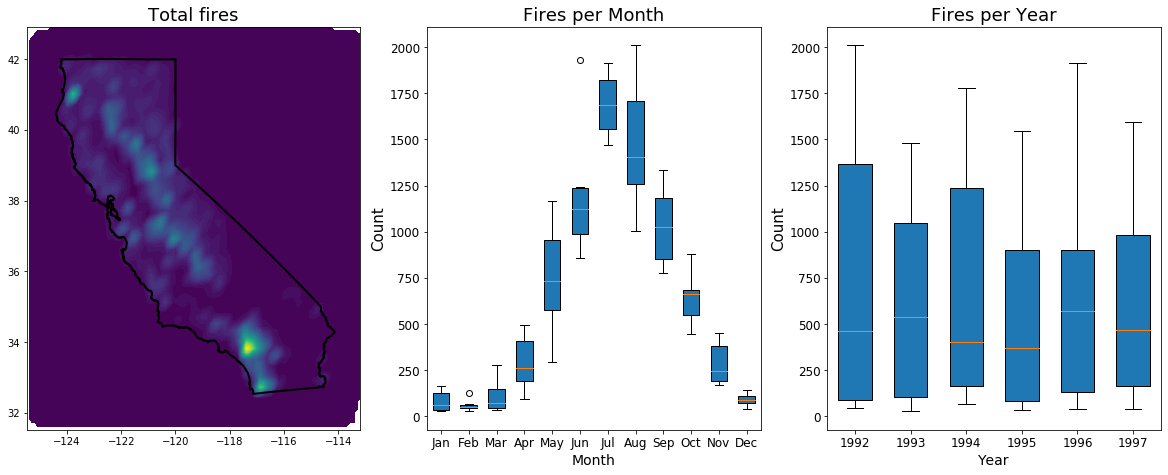

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(30, 7))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

x = fires_per_bin['lon']
y = fires_per_bin['lat']
z = fires_per_bin['ignition']

# target grid to interpolate to
xi = np.arange(LON_START, LON_END, GRID_SPACING)
yi = np.arange(LAT_START, LAT_END, GRID_SPACING)
xi2, yi2 = np.meshgrid(xi, yi)

# interpolate
zi = griddata((x, y), z, (xi2, yi2), method='linear')

ax[0].add_patch(PolygonPatch(california_land_mass, fc='none', ec='black', lw='2', zorder=2))
ax[0].contourf(xi, yi, zi, heatmap_contour_levels, cmap='viridis')
ax[0].set_title('Total fires', fontsize=18)

plot_data = [
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Jan'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Feb'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Mar'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Apr'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'May'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Jun'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Jul'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Aug'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Sep'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Oct'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Nov'],
    fires_per_month.ignition[fires_per_month['weather_bin_month'] == 'Dec']
]

ax[1].boxplot(plot_data, widths = 0.6, patch_artist = True)
ax[1].tick_params(labelsize=12)
ax[1].set_title('Fires per Month', fontsize=18)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].set_xticklabels([
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
])

plot_data = [
    fires_per_month.ignition[fires_per_month['weather_bin_year'] == 1992],
    fires_per_month.ignition[fires_per_month['weather_bin_year'] == 1993],
    fires_per_month.ignition[fires_per_month['weather_bin_year'] == 1994],
    fires_per_month.ignition[fires_per_month['weather_bin_year'] == 1995],
    fires_per_month.ignition[fires_per_month['weather_bin_year'] == 1996],
    fires_per_month.ignition[fires_per_month['weather_bin_year'] == 1997]
]

ax[2].boxplot(plot_data, widths = 0.6, patch_artist = True)
ax[2].tick_params(labelsize=12)
ax[2].set_title('Fires per Year', fontsize=18)
ax[2].set_xlabel('Year', fontsize=14)
ax[2].set_ylabel('Count', fontsize=15)
ax[2].set_xticklabels([
    '1992',
    '1993',
    '1994',
    '1995',
    '1996',
    '1997'
])

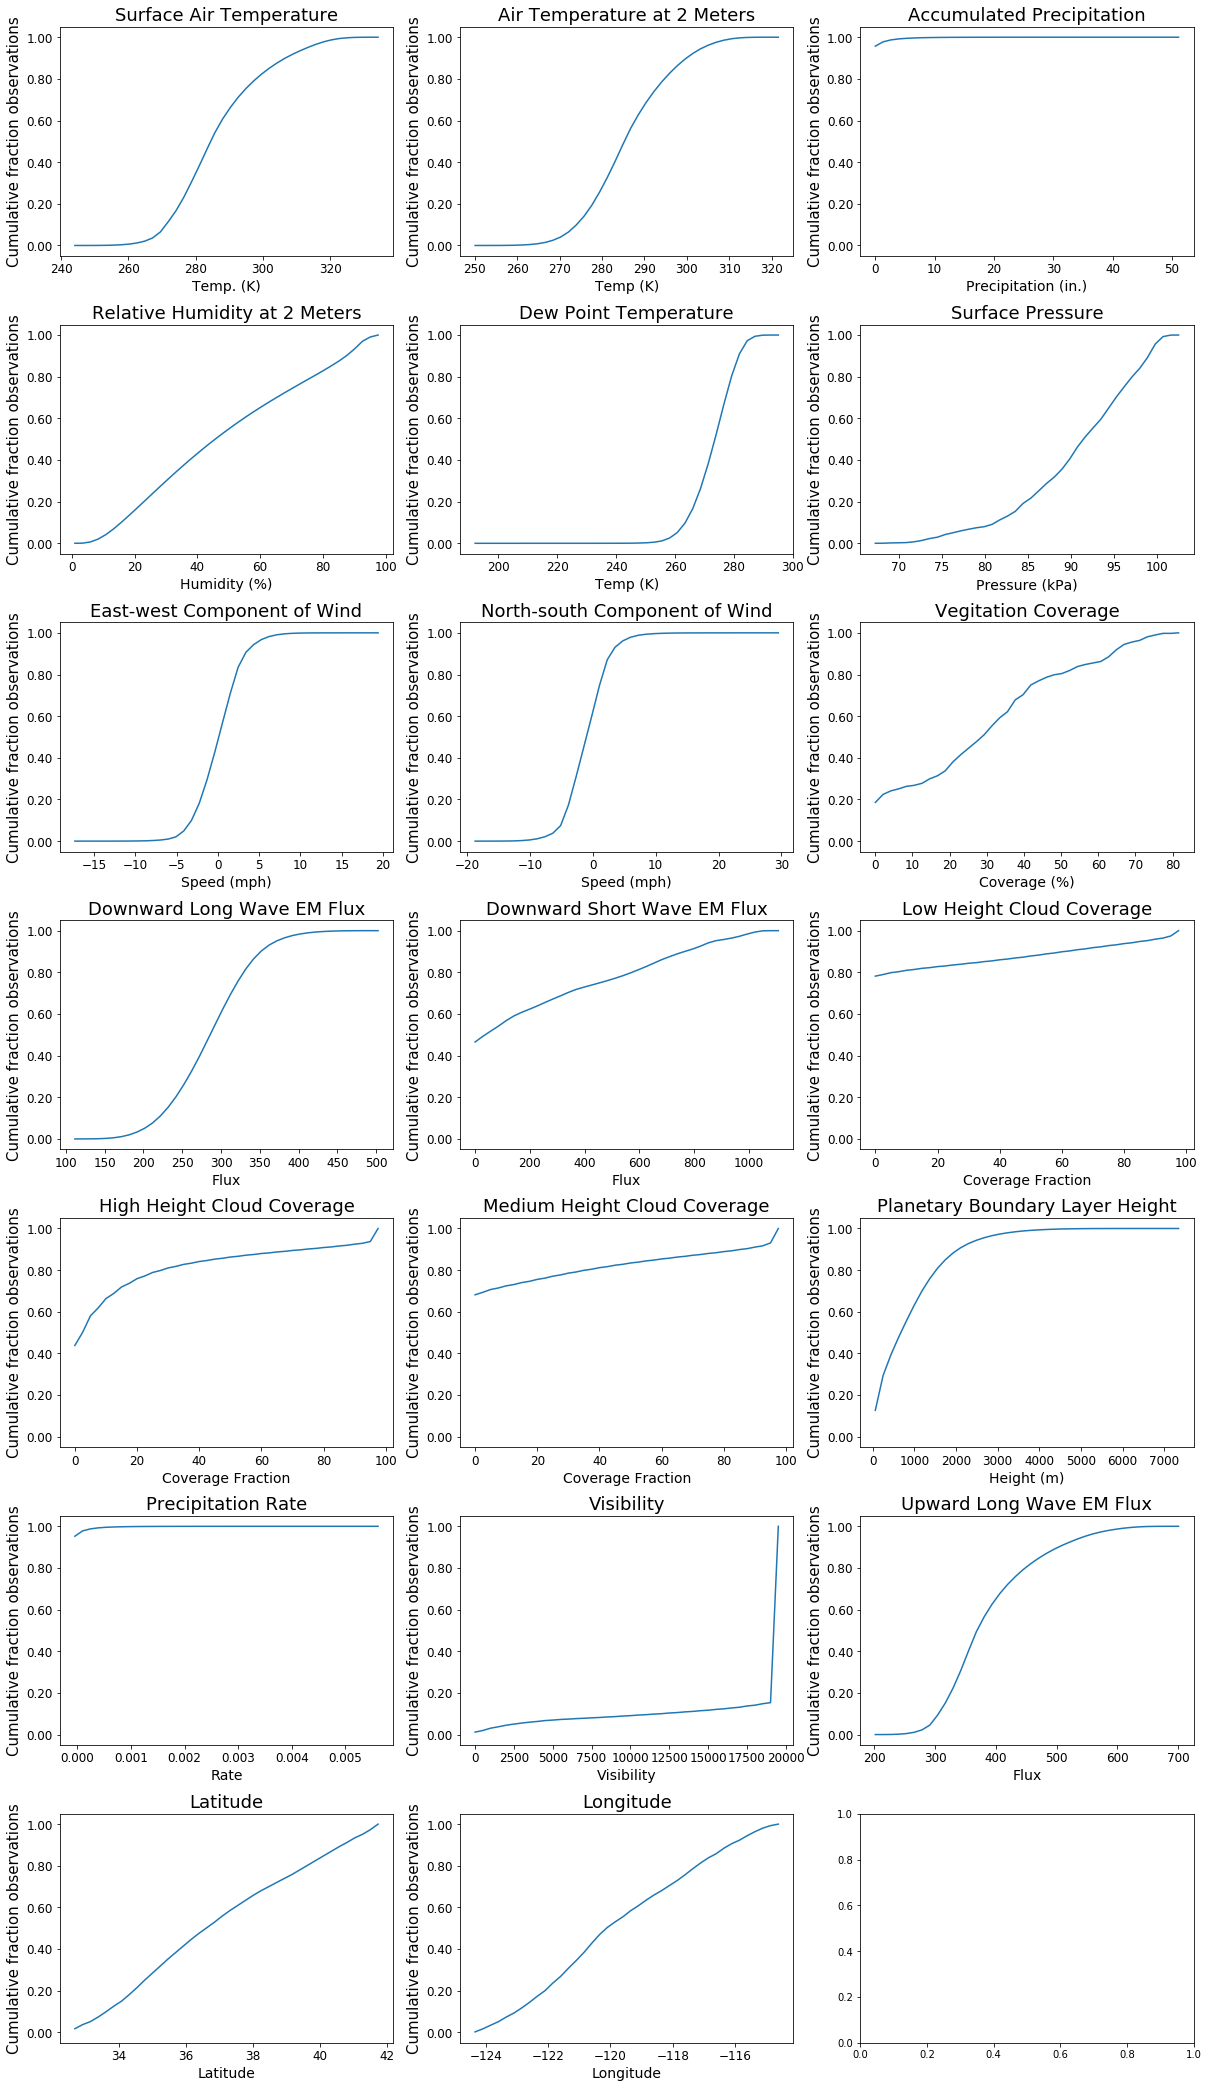

In [7]:
xlabels = weather_variable_labels
ylabels = ['Cumulative fraction observations'] * len(xlabels)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = CDF_plot(plot_locations[i], data, data_types[i], plot_titles[i], xlabels[i], ylabels[i])
    
plt.show()

In [8]:
box_data = pd.read_csv(weather_data_box)
box_data_one_hour = box_data[box_data['time'] == heatmap_time_subset]
box_data_one_hour = box_data_one_hour.fillna(0)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    xi, yi, zi = regularize_grid(box_data_one_hour, data_types[i])    
    ax[plot_locations[i]] = map_plot(plot_locations[i], california_land_mass, xi, yi, zi, plot_titles[i], heatmap_contour_levels)

KeyboardInterrupt: 

In [ ]:
ylabels = weather_variable_labels
xlabels = ['Fire ignition'] * len(ylabels)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = boxplot(plot_locations[i], no_ignition, ignition, data_types[i], plot_titles[i], xlabels[i], ylabels[i])
    
plt.show()

In [ ]:
xlabels = weather_variable_labels
ylabels = ['Ignition probability'] * len(xlabels)

num_bins = 11

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = binned_scatterplot(plot_locations[i], data_types[i], plot_titles[i], xlabels[i], ylabels[i], num_bins)
    
plt.show()

In [ ]:
correlation_matrix_all = data.corr()
mask = np.zeros_like(correlation_matrix_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style = "white")
cmap = 'viridis'

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlation_matrix_all, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()